In this notebook i'll apply ML algorithms for larceny occurrences in the Boston Crime Incidents dataset.

The dataset was preprocessed here: https://github.com/RaphaelRoriz/Machine_learning/blob/master/CrimeBoston/BostonCrime%20cleaning%20and%20analysis.ipynb

The original dataset can be downloaded here: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from noOccurrence_generator import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [3]:
#show the number of correct classification for both classes and the overall misclassification.
def compare_classPredictions(target,predicted):
    correct_class0 = correct_class1 = 0 #number of correct classifications for both classes
    dataSize = len(target)
    for i in range(0,dataSize):
        targetAux = target[i]
        if targetAux == 0 and targetAux == predicted[i]:
            correct_class0 +=1
        elif targetAux == 1 and targetAux == predicted[i]:
            correct_class1+=1
        else:
            pass
        
    print("Number of class 0 corrected classified: ",correct_class0)
    print("Number of class 1 corrected classified: ",correct_class1)
    print("Missclassified:", dataSize - (correct_class0+correct_class1))
            

# Importing dataset and generating synthetic entries

In [4]:
df = pd.read_csv('larcenyData.csv',encoding='latin1')

In [5]:
df

,Unnamed: 0,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,54,Larceny,C6,2019,9,7,3,42.340070,-71.052794
1,79,Larceny,D4,2019,9,6,23,42.344396,-71.086320
2,123,Larceny,E13,2019,9,6,20,42.319293,-71.111782
3,129,Larceny,C11,2019,9,6,19,42.291265,-71.068114
4,131,Larceny,C11,2019,9,6,19,42.295263,-71.072074
...,...,...,...,...,...,...,...,...,...
33613,426828,Larceny,D4,2016,6,7,17,42.336951,-71.085748
33614,426829,Larceny,D4,2016,6,7,17,42.336951,-71.085748
33615,426847,Larceny,B2,2018,12,4,0,42.309563,-71.089902
33616,426848,Larceny,B2,2018,12,4,0,42.309563,-71.089902


In [6]:
df.drop('Unnamed: 0',axis = 1, inplace=True)

We only have entries for occurrences in the dataset, so i created a no ocurrence generator, so we can train  classification algorithms with the data.

generator: https://github.com/RaphaelRoriz/Machine_learning/blob/master/CrimeBoston/noOccurrence_generator.py

In [7]:
#no-occurred entries generated from noOccurrence_generator
dfSynthetized = gen_syntheticData(len(df))

In [8]:
dfSynthetized

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,not occurred,E18,2016,2,1,15,42.312701,-71.099403
1,not occurred,A15,2016,2,1,8,42.351285,-71.008151
2,not occurred,B2,2016,7,2,12,42.384552,-71.167835
3,not occurred,D14,2017,11,3,0,42.381917,-71.045839
4,not occurred,B2,2017,6,2,5,42.299027,-71.018445
...,...,...,...,...,...,...,...,...
33613,not occurred,E13,2017,6,5,11,42.290169,-71.128954
33614,not occurred,E18,2016,12,5,16,42.389429,-71.074607
33615,not occurred,E18,2017,4,3,20,42.265412,-71.020883
33616,not occurred,B2,2018,1,3,19,42.371936,-71.176543


In [9]:
#dataset containing the larceny occurrencies and the synthetic no-occurrence data
larceny = pd.concat([df,dfSynthetized],axis = 0)

In [10]:
larceny

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,Larceny,C6,2019,9,7,3,42.340070,-71.052794
1,Larceny,D4,2019,9,6,23,42.344396,-71.086320
2,Larceny,E13,2019,9,6,20,42.319293,-71.111782
3,Larceny,C11,2019,9,6,19,42.291265,-71.068114
4,Larceny,C11,2019,9,6,19,42.295263,-71.072074
...,...,...,...,...,...,...,...,...
33613,not occurred,E13,2017,6,5,11,42.290169,-71.128954
33614,not occurred,E18,2016,12,5,16,42.389429,-71.074607
33615,not occurred,E18,2017,4,3,20,42.265412,-71.020883
33616,not occurred,B2,2018,1,3,19,42.371936,-71.176543


# Target column generation

- 1 = larceny occurrence
- 0 = no occurrence

In [11]:
def get_class(offense):
    #return the class of the occurrence: 1-> a larceny occurred 0-> no larceny occurrence
    if(offense == 'Larceny'):
        return 1
    else:
        return 0

In [12]:
larceny['occurred'] = larceny['OFFENSE_CODE_GROUP'].apply(get_class)

In [13]:
larceny

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred
0,Larceny,C6,2019,9,7,3,42.340070,-71.052794,1
1,Larceny,D4,2019,9,6,23,42.344396,-71.086320,1
2,Larceny,E13,2019,9,6,20,42.319293,-71.111782,1
3,Larceny,C11,2019,9,6,19,42.291265,-71.068114,1
4,Larceny,C11,2019,9,6,19,42.295263,-71.072074,1
...,...,...,...,...,...,...,...,...,...
33613,not occurred,E13,2017,6,5,11,42.290169,-71.128954,0
33614,not occurred,E18,2016,12,5,16,42.389429,-71.074607,0
33615,not occurred,E18,2017,4,3,20,42.265412,-71.020883,0
33616,not occurred,B2,2018,1,3,19,42.371936,-71.176543,0


In [14]:
larceny.drop('OFFENSE_CODE_GROUP',axis = 1, inplace=True)

# Shuffle the dataset 

In [15]:
larceny = larceny.sample(frac=1).reset_index(drop=True)

In [16]:
larceny

,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred
0,E18,2016,1,1,19,42.392067,-71.067064,0
1,E13,2017,8,2,22,42.263377,-71.136949,0
2,C6,2017,2,5,18,42.239639,-70.998371,0
3,D14,2017,5,7,10,42.336599,-71.164468,0
4,D4,2019,4,7,2,42.335119,-71.074917,1
...,...,...,...,...,...,...,...,...
67231,A7,2016,5,7,5,42.340100,-71.151992,0
67232,C6,2019,2,5,13,42.330916,-71.064151,1
67233,A1,2016,1,2,17,42.282441,-71.050755,0
67234,B2,2017,2,2,20,42.269098,-71.142937,0


# Dummy variables

In [17]:
larceny = pd.get_dummies(larceny,columns=['DISTRICT'],drop_first=True)

In [18]:
larceny.columns

Index(['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Lat', 'Long', 'occurred',
       'DISTRICT_A15', 'DISTRICT_A7', 'DISTRICT_B2', 'DISTRICT_B3',
       'DISTRICT_C11', 'DISTRICT_C6', 'DISTRICT_D14', 'DISTRICT_D4',
       'DISTRICT_E13', 'DISTRICT_E18', 'DISTRICT_E5'],
      dtype='object')

In [19]:
larceny

,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred,DISTRICT_A15,DISTRICT_A7,DISTRICT_B2,DISTRICT_B3,DISTRICT_C11,DISTRICT_C6,DISTRICT_D14,DISTRICT_D4,DISTRICT_E13,DISTRICT_E18,DISTRICT_E5
0,2016,1,1,19,42.392067,-71.067064,0,0,0,0,0,0,0,0,0,0,1,0
1,2017,8,2,22,42.263377,-71.136949,0,0,0,0,0,0,0,0,0,1,0,0
2,2017,2,5,18,42.239639,-70.998371,0,0,0,0,0,0,1,0,0,0,0,0
3,2017,5,7,10,42.336599,-71.164468,0,0,0,0,0,0,0,1,0,0,0,0
4,2019,4,7,2,42.335119,-71.074917,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67231,2016,5,7,5,42.340100,-71.151992,0,0,1,0,0,0,0,0,0,0,0,0
67232,2019,2,5,13,42.330916,-71.064151,1,0,0,0,0,0,1,0,0,0,0,0
67233,2016,1,2,17,42.282441,-71.050755,0,0,0,0,0,0,0,0,0,0,0,0
67234,2017,2,2,20,42.269098,-71.142937,0,0,0,1,0,0,0,0,0,0,0,0


# EDA

<Figure size 1080x720 with 0 Axes>

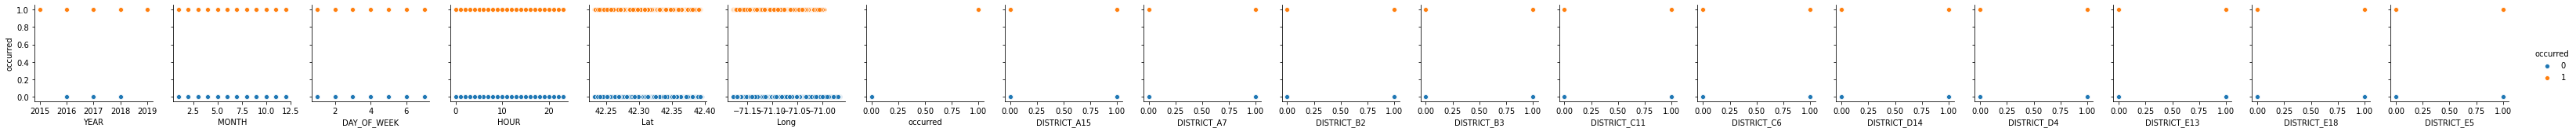

In [20]:
xVars = larceny.columns.tolist()
plt.figure(figsize=(15,10))
sns.pairplot(data = larceny,hue = "occurred",y_vars=['occurred'],x_vars=xVars)

# Train and test sets split

In [21]:
y = larceny['occurred']
X = larceny.drop(['occurred','YEAR'],axis = 1) #i'll remove the YEAR column,so it wont affect the model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## KFold

In [23]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

# Evaluating models

## Defining models

### 1)KNN

In [24]:
knnPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',KNeighborsClassifier())
]
)

### 2) Random Forest 

In [25]:
rfcPipeline = Pipeline(steps=[
    ('model',RandomForestClassifier())
]
)

### XGBoost

In [26]:
xgbPipeline = Pipeline(steps=[
    ('model',xgb.XGBClassifier())
]
)

## Evaluate

In [27]:
models = [
    ('knn',knnPipeline),
    ('rfc',rfcPipeline),
    ('xgb',xgbPipeline)
]

In [28]:
results = {}
names = []
scoring = 'accuracy'

In [29]:
#perform a cross validation for every model and store the results
for name,model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results[name] = cv_results

/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.p

In [30]:
results

{'knn': array([0.93441404, 0.93173198, 0.93046776, 0.93232691, 0.92942664]),
 'rfc': array([0.96936347, 0.9724102 , 0.97144344, 0.96921246, 0.97084852]),
 'xgb': array([0.97702261, 0.9770209 , 0.9765747 , 0.97627724, 0.97746709])}

In [31]:
average_results = {}
for key in results.keys():
    average_results[key] = np.sqrt(results[key]).sum()/5

In [32]:
average_results

{'knn': 0.9652319371967018, 'rfc': 0.9852183690149829, 'xgb': 0.98836858685946}

## Comparing predictions results and scores for the best model.

In [33]:
xgbPipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight...cale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None))])

In [34]:
#predictions
train_predictions = xgbPipeline.predict(X_train)
test_predictions =xgbPipeline.predict(X_test)

In [35]:
xgbPipeline.score(X_train,y_train)

0.9853181769892702

In [36]:
xgbPipeline.score(X_test,y_test)

0.9771454067720986

In [37]:
compare_classPredictions(y_train.tolist(),train_predictions.tolist())

Number of class 0 corrected classified:  23003
Number of class 1 corrected classified:  23371
Missclassified: 691


In [38]:
compare_classPredictions(y_test.tolist(),test_predictions.tolist())

Number of class 0 corrected classified:  9683
Number of class 1 corrected classified:  10027
Missclassified: 461


In [39]:
confusion_matrix(y_train, train_predictions)

array([[23003,   592],
       [   99, 23371]])

In [40]:
confusion_matrix(y_test,test_predictions)

array([[ 9683,   340],
       [  121, 10027]])